In [43]:
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from statistics import stdev
from collections import Counter
import matplotlib.patches as mpatches



In [2]:
df = pd.read_csv("data/noon_perfumes_dataset.csv", index_col=0)
df = df.drop_duplicates()
df

,brand,name,old_price,new_price,ml,concentration,department,scents,base_note,middle_note,item_rating,seller,seller_rating,num_seller_ratings
0,PACO RABANNE,1 Million Lucky,395.0,244.55,100,EDT,Men,Woody,"Oakmoss, Patchouli and Vetiver","Hazelnut, Jasmine, Cashmir Wood, Cedar and Honey",5.0,noon,4.2,98.1K
1,Roberto Cavalli,Paradiso Assoluto,415.0,107.95,50,EDP,Women,Floral,"Vanilla, Sandalwood And Patchouli",Wild Jasmine and Red Lily,4.8,noon,4.2,98.1K
2,S.T.Dupont,Royal Amber,265.0,186.90,100,EDP,Unisex,Arabian,"Lemon, Mint and Wood Moss",Sandalwood and Cedar,5.0,noon,4.2,98.1K
3,GUESS,Seductive Blue,290.0,103.20,100,EDT,Men,Spicy,"Cashmere Wood, Moss And Rippled Sand Accord",Blue Coral Aquaspace Accord And Geranium,3.0,noon,4.2,98.1K
4,Roberto Cavalli,Uomo,260.0,94.95,50,EDP,Women,Arabian,"Vanille, Benzoin, Tonka Bean",African Orange Flower,4.8,noon,4.2,98.1K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,HUGO BOSS,Bottled Night,688.0,250.00,200,EDT,Men,Woody,"Musk, Woody Notes",Violet,4.5,Lady Style,3.6,5
995,BVLGARI,Petits Et Mamans,327.0,197.75,100,EDT,Women,Floral,Iris and Vanilla,White Peach,4.8,Tiffany,4.1,75
997,Roberto Cavalli,Paradiso Azzurro,499.0,165.00,75,EDP,Women,Fruity,"Cypress, Cashmere Wood, Amber wood, Sandalwood...","Wild Jasmine, Watery Notes, Apple, Tuberose, P...",4.7,Beauty Group,4.3,124
999,BURBERRY,For Women EDP Natural Sp,378.0,153.75,100,EDT,Women,Fruity,Musk And Vanilla,"Woody-Floral, Sandalwood And Cedar",4.8,noon,4.2,98.1K


In [3]:
df.loc[df['base_note'].isin(['Accord'])]

,brand,name,old_price,new_price,ml,concentration,department,scents,base_note,middle_note,item_rating,seller,seller_rating,num_seller_ratings


## Supervised Learning

#### Predicting gender M/F based on base notes, middle notes and scent

In [176]:
df = df[(df["department"] != "Kids Unisex")]
df = df[(df["department"] != "Unisex")]  #We remove kids and unisex because they are small in relation to M/W
#Labels
gender = df["department"].values
#Features
base_note = df["base_note"].values
middle_note = df["middle_note"].values
scents = df["scents"].values

In [177]:
vectorizer = CountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
X1 = vectorizer.fit_transform(base_note)
len(vectorizer.get_feature_names_out())


318

We have 'muscs', 'musk', 'musks', 'musky' which we want to treat the same, therefore we will preprocess some more use stemming provided by NLTK plus some a priori replacement

In [178]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
def replace(t):

    if "amber" in t:
        t = "amber"
    if "cash" in t:
        t = "cashmere"
    if "flo" in t:
        t = "floral"
    if "ced" in t:
        t = "cedar"
    if "mu" in t:
        t = "musk"
    if "leather" in t:
        t = "leather"
    if "lil" in t:
        t = "lily"
    if "lacton" in t:
        t = "lacton"
    if "labda" in t:
        t = "labdanum"
    if "patch" in t:
        t = "patchouli"
    if "vanil" in t:
        t = "vanilla"
    if "oud" in t:
        t = "oud"
    if "oliv" in t:
        t = "olive"
    if "sand" in t:
        t = "sandalwood"
    if "wood" in t[:4]:
        t = "wood"

    return t
            
class StemmedCountVectorizer(CountVectorizer):
    
     def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(replace(w)) for w in analyzer(doc)])
    
#    def build_tokenizer(self):
#        tokenize = super().build_tokenizer()
#        return lambda doc: list(replace(tokenize(doc)))

class ReplaceCountVectorizer(CountVectorizer):
    
     def build_analyzer(self):
        analyzer = super(ReplaceCountVectorizer, self).build_analyzer()
        return lambda doc: ([replace(w) for w in analyzer(doc)])
    

In [179]:
vect_base = StemmedCountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vect_middle = StemmedCountVectorizer(stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vect_scents = StemmedCountVectorizer(stop_words = ['and'])

X1 = vect_base.fit_transform(base_note)
X2 = vect_middle.fit_transform(middle_note)
X3 = vect_scents.fit_transform(scents)

In [180]:
random.state = 43

X_comb = np.hstack((X1.toarray(), X2.toarray(), X3.toarray()))

nb = BernoulliNB()
p = Perceptron()
mlp = MLPClassifier(max_iter = 500, solver = 'lbfgs')
rf = RandomForestClassifier(n_estimators = 500)
knn = KNeighborsClassifier(metric='jaccard', n_neighbors=1)
svm = SVC()
baseline = DummyClassifier(strategy='most_frequent')

classifiers = {"NB": nb, "P": p, "MLP": mlp, "RF": rf, "kNN": knn, "SVM": svm, "baseline": baseline}

In [181]:
X1.toarray().shape, X2.toarray().shape, X3.toarray().shape

((842, 273), (842, 401), (842, 15))

### Base notes only

In [ ]:
base_scores = {}
base_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X1.toarray().astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X1.toarray(), gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    base_scores[name] = mean
    base_stdevs[name] = std

In [ ]:
base_scores

#### Middle Notes

In [ ]:
mid_scores = {}
mid_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X2.toarray().astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X2.toarray(), gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    mid_scores[name] = mean
    mid_stdevs[name] = std
print(mid_scores)

#### Scents

In [ ]:
scent_scores = {}
scent_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X3.toarray().astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X3.toarray(), gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    scent_scores[name] = mean
    scent_stdevs[name] = std
print(scent_scores)

### All Features

In [ ]:
comb_scores = {}
comb_stdevs = {}
for name, clf in classifiers.items():
    if name == "kNN":
        scores = cross_val_score(clf,X_comb.astype('bool'), gender, cv=5)
    else:
        scores = cross_val_score(clf,X_comb, gender, cv=5)
    mean = scores.mean()
    std = stdev(scores)
    comb_scores[name] = mean
    comb_stdevs[name] = std
print(comb_scores)

In [ ]:
def roundd(scoredict, n):
    for k, v in scoredict.items():
        scoredict[k] = round(v,n)
    return scoredict

In [ ]:
base_scores = roundd(base_scores,2)
mid_scores = roundd(mid_scores,2)
scent_scores = roundd(scent_scores,2)
comb_scores = roundd(comb_scores,2)

rows_list = [base_scores, mid_scores, scent_scores, comb_scores]
res = pd.DataFrame(rows_list)
res[" "] = ["Base Notes", "Middle Notes", "Scents", "Features Combined"]
res = res.set_index([" "])
res

In [ ]:
res.to_csv("table2.csv")

### SVM Grid Search

In [182]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1)
grid1 = grid.fit(X1,gender)
grid2 = grid.fit(X2,gender)
grid3 = grid.fit(X3,gender)
grid4 = grid.fit(X_comb,gender)

grid_scores_base = cross_val_score(grid1, X1, gender)
grid_scores_mid = cross_val_score(grid2, X2, gender)
grid_scores_scent = cross_val_score(grid3, X3, gender)
grid_scores_comb = cross_val_score(grid4, X_comb, gender)

print(grid_scores_base.mean())
print(grid_scores_mid.mean())
print(grid_scores_scent.mean())
print(grid_scores_comb.mean())


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 

In [184]:
grid1.best_estimator_, grid2.best_estimator_,grid3.best_estimator_,grid4.best_estimator_

(SVC(C=10, gamma=0.1),
 SVC(C=10, gamma=0.1),
 SVC(C=10, gamma=0.1),
 SVC(C=10, gamma=0.1))

## Plotting 

In [155]:
# We will include the top 40 notes for base and middle
vect_base = ReplaceCountVectorizer(max_features = 8, stop_words = ['accord', 'accords', 'note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
vect_middle = ReplaceCountVectorizer(max_features = 8, stop_words = ['of', 'the', 'valley', 'note', 'notes', 'and', 'with', 'ectract', 'co', 'essence', 'masculine'])
vect_scents = ReplaceCountVectorizer(max_features = 8, stop_words = ['note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])

X1 = vect_base.fit_transform(base_note)
X2 = vect_middle.fit_transform(middle_note)

X3 = vect_scents.fit_transform(scents)


In [153]:
#gender = df["department"].apply(lambda y: 'Men' if y == 'Unisex' else y)
df = df[df.department != "Unisex"]


scent_names = vect_scents.get_feature_names_out()
base_names = vect_base.get_feature_names_out()
middle_names = vect_middle.get_feature_names_out()

scent_df = pd.DataFrame(X3.todense(), columns = scent_names)
#scent_df_all = pd.DataFrame(X4.todense(), columns = scent_names_all)
base_df = pd.DataFrame(X1.todense(), columns = base_names)
middle_df = pd.DataFrame(X2.todense(), columns = middle_names)

mlb = LabelEncoder()

scent_df['gender'] = mlb.fit_transform(gender)

base_df['gender'] = scent_df['gender']
middle_df['gender'] = scent_df['gender']



In [85]:

mens_count = np.count_nonzero(scent_df['gender'] == 0)
womens_count = np.count_nonzero(scent_df['gender'] == 1)

men_scents = {}
women_scents = {}

scent_counts = np.zeros(shape=(len(scent_names),2))
for i, scent in enumerate(scent_names):
    men_scents[scent] = np.count_nonzero(np.logical_and(scent_df['gender'] == 0, scent_df[scent] == 1))
    women_scents[scent] = np.count_nonzero(np.logical_and(scent_df['gender'] == 1, scent_df[scent] == 1))
    
    scent_counts[i,0] = men_scents[scent]/mens_count
    scent_counts[i,1] =  women_scents[scent]/womens_count

scent_counts *= 100


In [120]:
bar_labels = np.empty((6,2), dtype = 'object')
for i in range(len(scent_counts)):
    for j in range(2):
        bar_labels[i,j] = scent_names[i] + ", {:.1f}".format(scent_counts[i,j]) + "%"

bar_labels[5,0] = "Other, {:.1f}".format(100-sum(scent_counts[:,0])) + "%"
bar_labels[5,1] = "Other, {:.1f}".format(100-sum(scent_counts[:,1])) + "%"


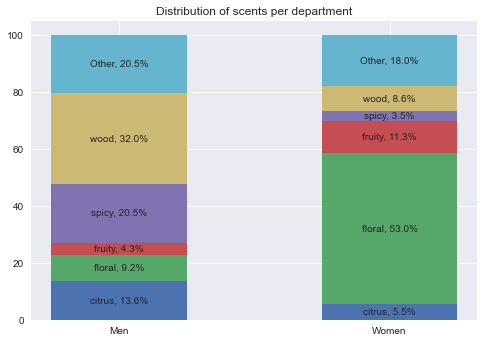

In [121]:
plt.style.use('seaborn')
labels = ["Men", "Women"]

width = 0.5   

fig, ax = plt.subplots()
bars = []
bars.append(ax.bar(labels, scent_counts[0], width, label=scent_names[0]))
for i in range(1,len(scent_counts)):

    bars.append(ax.bar(labels, scent_counts[i], width, bottom=sum(scent_counts[:i]), label=scent_names[i]))

bars.append(ax.bar(labels, 100-sum(scent_counts), width, bottom=sum(scent_counts), label="other"))

ax.set_title('Distribution of scents per department')

for i, bar in enumerate(bars[:5]):
    plt.bar_label(bar, labels = bar_labels[i], label_type ='center')

plt.bar_label(bars[5], labels = bar_labels[5], label_type = 'center')

plt.savefig('scents_dpt.png', dpi = 300)
plt.show()


In [146]:
def visualize_distribution(df, names, ax):
    mens_total = np.count_nonzero(df['gender'] == 0)
    womens_total = np.count_nonzero(df['gender'] == 1)
  
    counts = np.zeros(shape=(len(names),2))
    for i, feat in enumerate(names):
        men = np.count_nonzero(np.logical_and(df['gender'] == 0, df[feat] == 1))
        women = np.count_nonzero(np.logical_and(df['gender'] == 1, df[feat] == 1))

        counts[i,0] = men/mens_total
        counts[i,1] =  women/womens_total

    counts *= 100
    print(counts)
    bar_labels = np.empty((6,2), dtype = 'object')
    for i in range(len(counts)):
        for j in range(2):
            bar_labels[i,j] = names[i] + ", {:.1f}".format(counts[i,j]) + "%"

    bar_labels[5,0] = "Other, {:.1f}".format(100-sum(counts[:,0])) + "%"
    bar_labels[5,1] = "Other, {:.1f}".format(100-sum(counts[:,1])) + "%"
    
    labels = ["Men", "Women"]
    width = 0.5   
    bars = []
 
    bars.append(ax.bar(labels, counts[0], width))
    for i in range(1,len(counts)):
 
        bars.append(ax.bar(labels, counts[i], width, bottom=sum(counts[:i])))

    bars.append(ax.bar(labels, 100-sum(counts), width, bottom=sum(counts)))


    return bars, bar_labels
  #  plt.show()

#### Scatterplot: Correlation with gender (X) and Frequency (Y) 

ValueError: x and y must be the same size

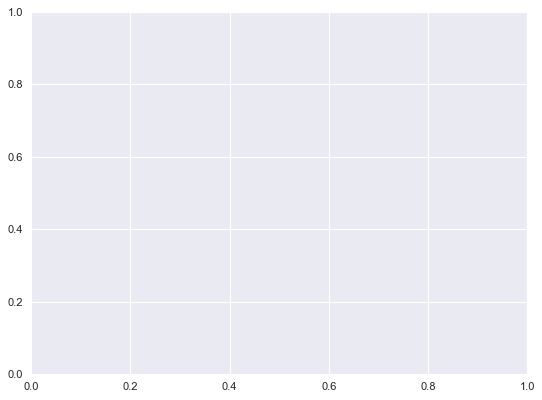

In [183]:
X = scent_df.corr().iloc[-1][:-1] # Correlation between scents and gender M/F
Y = sum(X3.toarray())
plt.style.use('seaborn')
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(scent_names[i], d, ha='center', va='center', c='r') # Fontsize needs to be scaled, I thought this was optimal to keep everything readable

X = base_df.corr().iloc[-1][:-1] # Correlation between base and gender M/F
Y = sum(X1.toarray())
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(base_names[i], d, ha='center', va='center', c='b')
    
X = middle_df.corr().iloc[-1][:-1] # Correlation between midnotes and gender M/F
Y = sum(X2.toarray())
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(middle_names[i], d, ha='center', va='center', c='g')
    
patch1 = mpatches.Patch(color='r',label='Scents') 
patch2 = mpatches.Patch(color='b', label='Base Notes') 
patch3 = mpatches.Patch(color='g', label='Middle Notes')
plt.legend(framealpha=1, handles=[patch1, patch2, patch3])

plt.xlim(-0.5, 0.5)
plt.title("Correlation with department (Men/Women) and frequency for most common features")
plt.ylabel("Number of occurences")
plt.xlabel("Correlation")
#plt.savefig("Correlation2.png",dpi=300)

As we can see, manly-man notes such as 'leather', 'cedar' and 'tobacco' are to the left and girly-girl notes such as 'praline', 'caramel', 'rose' and 'vanilla' are to the right

#### MIDDLE Notes Scatterplot: Correlation with gender (X) and Average Price (Among perfumes where note is present) (Y) 

Middle Notes, mean price

In [ ]:
mean_prices_middle = []
for note in middle_names:
    mean = df.price_ml[df['middle_note'].str.contains(note, case=False)].mean()
    mean_prices_middle.append(mean)

In [ ]:
len(mean_prices_middle), len(middle_names)

In [ ]:
middle_names

In [ ]:
X = middle_df.corr().iloc[-1][:-1] # Correlation between middle notes and gender M/F
Y = mean_prices_middle # Mean price for each
Z = sum(X2.toarray()) #Frequency (will be mapped to font size)
plt.style.use('seaborn')
plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(X,Y, s =0)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(middle_names[i], d, ha='center', va='center',fontsize = Z[i]/20 + 10) # Fontsize needs to be scaled, I thought this was optimal to keep everything readable

In [ ]:
X1.toarray().shape

In [ ]:
dict(zip(vect_base.get_feature_names_out(),sum(X1.toarray())))

In [125]:
scent

'vanilla'